In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import featexp
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [2]:
#extrcation de features automatisé

### In this notebook you will find  :
 - Basic data exploration 
 - First implementation of a binary classification using the 1) review length and 2)title as well as 3)two colums that indicate if the review and title started with a capital letter + 4) onehot encoding of the review stars
 - Second implementation using the example seen in class TfidfVectorizer
 - In both cases RandomForestClassifier was the algorithm of choice
 - Both models use train, test, validation set
 - You can see the ROC curves for both models with the auc score
 - First model gives an accuracy of 56% while the second one gives 65% of accuracy

In [3]:
data = pd.read_csv("train_master.csv")

Data exploration

In [4]:
data

,Unnamed: 0,ID,review_content,review_title,review_stars,product,Target
0,0,0,En appelant un acheteur pour demander si l'écr...,La Police s'inscrit en acheteur privé sur Pric...,5,2fbb619e3606f9b7c213e858a109cda771aa2c47ce50d5...,0
1,1,1,"Alors, là, on a affaire au plus grand Navet ja...",Chef D'Oeuvre Absolu en vue...,5,7b56d9d378d9e999d293f301ac43d044cd7b4786d09afb...,1
2,2,2,Effet garanti sur la terrase. Ils donnent immé...,Effet garanti sur la terrase. Ils donnent immé...,3,7b37bf5dcb2fafd9229897910318a7dfa11a04ca36893c...,0
3,4,4,Ordinateur de bureau trés bien pour quelqu'un ...,Apple Power MAC G4,3,f574512e7d2dd1dd73c7f8f804bf16f14c932c5651a01b...,1
4,5,5,"Ma fille adore, elle n'en n'était pas sûre à l...",Comme Hermione,5,a1a58f0f3a35a164fa14bff9e2c1ca8c1202c31499faa1...,1
...,...,...,...,...,...,...,...
54131,59995,59995,"Bonjour, je suis intereser par votre annonce e...",moto,5,675ebad7919f00b9cb4adb1469054240d8c76018dc27d2...,1
54132,59996,59996,Voline nous raconte en détail un aspect beauco...,Un témoignage fort contre l'oubli,4,a15a274f7d11ed085c745246bb078098e501198956eeeb...,1
54133,59997,59997,D'une bonne matière flexible ce double saura s...,Double plaisir,5,32a26794184ba74118c581b1659e85c2133227e18e97c2...,1
54134,59998,59998,très bien pour compléter des collections de fè...,tres bien,5,018af320f0b08e59032011e0bbc68d42f9486833c0482e...,1


In [5]:
data['Target'].value_counts()

1    29997
0    24139
Name: Target, dtype: int64

In [6]:
data['review_stars'].value_counts()

5    34609
4    10227
3     4147
1     3503
2     1650
Name: review_stars, dtype: int64

In [7]:
data['review_length']  = data['review_content'].str.len()
data['title_length'] = data['review_title'].str.len()


In [8]:
data.isnull().sum()

Unnamed: 0        0
ID                0
review_content    0
review_title      3
review_stars      0
product           0
Target            0
review_length     0
title_length      3
dtype: int64

as we have very few nan values we can drop the empty rows, it will not impact globally on our model

In [9]:
data = data.dropna()

In [10]:
data['first_letter'] = data['review_content'].astype(str).str[0]
data['first_letter_title'] = data['review_title'].astype(str).str[0]

/tmp/ipykernel_8179/3562881052.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['first_letter'] = data['review_content'].astype(str).str[0]
/tmp/ipykernel_8179/3562881052.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['first_letter_title'] = data['review_title'].astype(str).str[0]


Extract the first letter then create a predicate if the review or title starts with a capital letter

In [11]:
data['is_upper'] = data['first_letter'].str.isupper()
data['is_upper_title'] = data['first_letter_title'].str.isupper()

/tmp/ipykernel_8179/1983677762.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_upper'] = data['first_letter'].str.isupper()
/tmp/ipykernel_8179/1983677762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_upper_title'] = data['first_letter_title'].str.isupper()


If we explore better our data we can see that review_stars column can de considered as a categorical value, so it os interesting to apply a onehot encoder to see its impact on the model

In [12]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(data[['review_stars']]).toarray())

In [13]:
data = data.join(enc_df)

In [15]:
data

,Unnamed: 0,ID,review_content,review_title,review_stars,product,Target,review_length,title_length,first_letter,first_letter_title,is_upper,is_upper_title,0,1,2,3,4
0,0,0,En appelant un acheteur pour demander si l'écr...,La Police s'inscrit en acheteur privé sur Pric...,5,2fbb619e3606f9b7c213e858a109cda771aa2c47ce50d5...,0,382,55.0,E,L,True,True,0.0,0.0,0.0,0.0,1.0
1,1,1,"Alors, là, on a affaire au plus grand Navet ja...",Chef D'Oeuvre Absolu en vue...,5,7b56d9d378d9e999d293f301ac43d044cd7b4786d09afb...,1,1000,30.0,A,C,True,True,0.0,0.0,0.0,0.0,1.0
2,2,2,Effet garanti sur la terrase. Ils donnent immé...,Effet garanti sur la terrase. Ils donnent immé...,3,7b37bf5dcb2fafd9229897910318a7dfa11a04ca36893c...,0,194,97.0,E,E,True,True,0.0,0.0,1.0,0.0,0.0
3,4,4,Ordinateur de bureau trés bien pour quelqu'un ...,Apple Power MAC G4,3,f574512e7d2dd1dd73c7f8f804bf16f14c932c5651a01b...,1,124,18.0,O,A,True,True,0.0,0.0,1.0,0.0,0.0
4,5,5,"Ma fille adore, elle n'en n'était pas sûre à l...",Comme Hermione,5,a1a58f0f3a35a164fa14bff9e2c1ca8c1202c31499faa1...,1,102,14.0,M,C,True,True,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54131,59995,59995,"Bonjour, je suis intereser par votre annonce e...",moto,5,675ebad7919f00b9cb4adb1469054240d8c76018dc27d2...,1,98,4.0,B,m,True,False,0.0,0.0,0.0,0.0,1.0
54132,59996,59996,Voline nous raconte en détail un aspect beauco...,Un témoignage fort contre l'oubli,4,a15a274f7d11ed085c745246bb078098e501198956eeeb...,1,516,33.0,V,U,True,True,0.0,0.0,0.0,0.0,1.0
54133,59997,59997,D'une bonne matière flexible ce double saura s...,Double plaisir,5,32a26794184ba74118c581b1659e85c2133227e18e97c2...,1,73,14.0,D,D,True,True,NaN,NaN,NaN,NaN,NaN
54134,59998,59998,très bien pour compléter des collections de fè...,tres bien,5,018af320f0b08e59032011e0bbc68d42f9486833c0482e...,1,80,9.0,t,t,False,False,NaN,NaN,NaN,NaN,NaN


In [16]:
data = data.dropna()

We chose our X and y

In [17]:
X = data[['is_upper_title',
         'review_length', 'title_length','is_upper',0,1,2,3,4]]
y = data[['Target']]

In [18]:
print(data.review_content[0])

En appelant un acheteur pour demander si l'écran qu'il m'as acheté fonctionne toujours, il m'a répondu depuis le commissariat. Il était venu retirer l'objet en précisant à l'entrée de mon domicile "je suis policier", il est resté assis et m'a posé des questions sans rapport avec l'objet a retirer. Son numéro inscrit sur Priceminister renvoi au poste de son bureau au commissariat.


In [19]:
X

,is_upper_title,review_length,title_length,is_upper,0,1,2,3,4
0,True,382,55.0,True,0.0,0.0,0.0,0.0,1.0
1,True,1000,30.0,True,0.0,0.0,0.0,0.0,1.0
2,True,194,97.0,True,0.0,0.0,1.0,0.0,0.0
3,True,124,18.0,True,0.0,0.0,1.0,0.0,0.0
4,True,102,14.0,True,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
54128,True,299,19.0,True,0.0,0.0,0.0,0.0,1.0
54129,True,99,9.0,True,0.0,0.0,0.0,1.0,0.0
54130,False,104,37.0,False,0.0,0.0,0.0,0.0,1.0
54131,False,98,4.0,True,0.0,0.0,0.0,0.0,1.0


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [21]:
clf = RandomForestClassifier(n_estimators = 100)  

In [22]:
clf.fit(X_train, y_train)
  
# performing predictions on the test dataset
y_pred = clf.predict(X_test)
y_pred_val = clf.predict(X_val)

/tmp/ipykernel_8179/3370698913.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


In [23]:
from sklearn import metrics  

metrics.accuracy_score(y_val, y_pred_val)

0.5653981156475152

In [24]:
metrics.accuracy_score(y_test, y_pred)

0.5716792905967116

In [25]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.5920490915767913

In [26]:
roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])

0.5877608911081442

In [27]:
from sklearn.metrics import roc_curve  
def plot_roc_curve(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

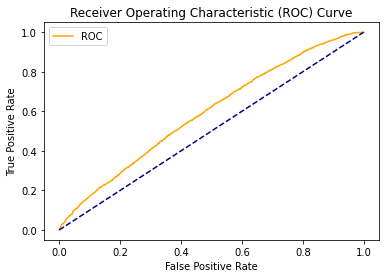

In [28]:
probs = clf.predict_proba(X_test)  
probs = probs[:, 1]  
fper, tper, thresholds = roc_curve(y_test, probs) 
plot_roc_curve(fper, tper)

### Second model using TfidVectorizer

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'french')

In [31]:

X_train_bis, X_test_bis, y_train_bis, y_test_bis = train_test_split(data.review_content, data.Target, test_size=.2, random_state=42)
X_train_bis, X_val_bis, y_train_bis, y_val_bis = train_test_split(X_train_bis, y_train_bis, test_size=0.25, random_state=1)

In [32]:
vectorizer = TfidfVectorizer().fit(X_train_bis)

In [33]:
trans_X_train = vectorizer.transform(X_train_bis.tolist())
trans_X_test = vectorizer.transform(X_test_bis.tolist())
trans_X_val =  vectorizer.transform(X_val_bis.tolist())

In [34]:
clf2 = RandomForestClassifier(n_estimators = 100).fit(trans_X_train,y_train_bis)

In [35]:
y_pred_bis = clf2.predict(trans_X_test)
y_pred_bis_val = clf2.predict(trans_X_val)


In [36]:
metrics.accuracy_score(y_val_bis, y_pred_bis_val)

0.6584149270275264

In [37]:
metrics.accuracy_score(y_test_bis, y_pred_bis)

0.6505634583410308

In [38]:
from sklearn.metrics import roc_auc_score

In [39]:
roc_auc_score(y_test_bis, clf2.predict_proba(trans_X_test)[:, 1])

0.7133769210280405

In [40]:
roc_auc_score(y_val_bis, clf2.predict_proba(trans_X_val)[:, 1])

0.715558743243187

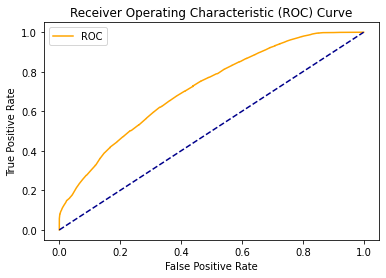

In [41]:
probs = clf2.predict_proba(trans_X_test)  
probs = probs[:, 1]  
fper, tper, thresholds = roc_curve(y_test_bis, probs) 
plot_roc_curve(fper, tper)

In [42]:
#Save  model
import pickle
# save the model to disk
pickle.dump(clf2, open('app/model/random_model.model', 'wb'))
pickle.dump(vectorizer, open("app/model/tfidf.pickle", "wb"))


### Third part

In this part we are combining many types of features set : tfidvectorizer, review_stars, review_length,title_length

In [59]:
data = pd.read_csv("train_master.csv")

In [60]:
data['review_length']  = data['review_content'].str.len()
data['title_length'] = data['review_title'].str.len()

In [61]:
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'french')

In [62]:
X_train_bis, X_test_bis, y_train_bis, y_test_bis = train_test_split(data.drop(columns=['Target']), data.Target, test_size=.2, random_state=42)
X_train_bis, X_val_bis, y_train_bis, y_val_bis = train_test_split(X_train_bis, y_train_bis, test_size=0.25, random_state=1)

In [63]:
vectorizer = TfidfVectorizer().fit(X_train_bis.review_content)

In [64]:
trans_X_train = vectorizer.transform(X_train_bis.review_content.tolist())
trans_X_test = vectorizer.transform(X_test_bis.review_content.tolist())
trans_X_val =  vectorizer.transform(X_val_bis.review_content.tolist())

In [65]:
from scipy.sparse import hstack

In [66]:
trans_X_train=hstack([trans_X_train,X_train_bis[['review_length','title_length','review_stars']]])


<32481x49558 sparse matrix of type '<class 'numpy.float64'>'
	with 874611 stored elements in COOrdinate format>

In [69]:
clf2 = RandomForestClassifier(n_estimators = 100).fit(trans_X_train,y_train_bis)

In [71]:
y_pred_bis = clf2.predict(trans_X_test)
y_pred_bis_val = clf2.predict(trans_X_val)

In [72]:
roc_auc_score(y_test_bis, clf2.predict_proba(trans_X_test)[:, 1]),roc_auc_score(y_val_bis, clf2.predict_proba(trans_X_val)[:, 1])

(0.7197490119205603, 0.7076759079885576)

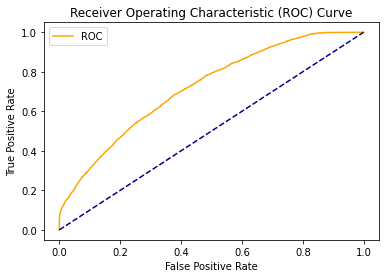

In [73]:
probs = clf2.predict_proba(trans_X_test)  
probs = probs[:, 1]  
fper, tper, thresholds = roc_curve(y_test_bis, probs) 
plot_roc_curve(fper, tper)